In [1]:
import pandas as pd
import numpy as np

from scipy.cluster import hierarchy as sch
from bertopic import BERTopic

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

In [2]:
data = pd.read_csv('scraping/full_clean_lemma_topic.csv')

In [3]:
# avoid umap pynndescent conflicts with numpy >= 1.21
import numba
@numba.njit(fastmath=True)
def correct_alternative_cosine(ds):
    result = np.empty_like(ds)
    for i in range(ds.shape[0]):
        result[i] = 1.0 - np.power(2.0, ds[i])
    return result

import pynndescent
pynn_dist_fns_fda = pynndescent.distances.fast_distance_alternatives
pynn_dist_fns_fda["cosine"]["correction"] = correct_alternative_cosine
pynn_dist_fns_fda["dot"]["correction"] = correct_alternative_cosine

In [131]:
docs = data[data['topic'].isna()].reset_index()['clean_lemma']

In [132]:
topic_model = BERTopic(verbose=True,language='french',embedding_model="all-MiniLM-L6-v2") #leaving default c-TF-IDF
topics, probs = topic_model.fit_transform(docs)

Batches:   0%|          | 0/700 [00:00<?, ?it/s]

2023-01-14 23:17:47,981 - BERTopic - Transformed documents to Embeddings
2023-01-14 23:18:10,873 - BERTopic - Reduced dimensionality
2023-01-14 23:18:14,308 - BERTopic - Clustered reduced embeddings


In [133]:
topic_model.get_topic_info() # -1 refers to all outliers : noise topic.

,Topic,Count,Name
0,-1,10026,-1_macron_france_pen_présidentielle
1,0,465,0_guerre_ukraine_réfugié_combat
2,1,319,1_covid_19_restriction_sanitaire
3,2,311,2_français_langue_balcon_start
4,3,291,3_psg_ligue_monaco_real
...,...,...,...
243,242,10,242_adopte_parlement_allongement_délai
244,243,10,243_rénovation_pissevin_helenis_guid
245,244,10,244_rsa_contrepartie_assistanat_bénévolat
246,245,10,245_toulon_biarritz_lou_enfiler


In [134]:
# Hierarchical topics
linkage_function = lambda x: sch.linkage(x, 'complete', optimal_ordering=True) # Farthest Neighbor Algorithm for somewhat conservative clustering
hierarchical_topics = topic_model.hierarchical_topics(docs, linkage_function=linkage_function)

100%|██████████| 246/246 [00:01<00:00, 137.28it/s]


In [378]:
topics_to_merge = [
[105,122,223,58,175,236,174,198,242,231,156,6,100,65,16,200,101,216,215,226,19,68,48,39,88,51,14,173,
69,84,29,81], #Politique France
[24,20,149,30,96,192,104,202,64,164,142,7,26,85,148,56,120,41,118,45,25,0,4,8,47,35,232,157,75,217,180,
222,178,190,98,77,82,195,129], #International
[153,220,204,218,214,143,124,237,22,132,36,79,3,230,166,11,208,183,76,212,72,42,209], #Sports
[63,78,12,2,116,155,18,62,145,196,133,50,227,60,245,241,112,134,154,233,49,119,182,240,135,186,163,57,
80,221,32,86,33,146], #Société
[5,158,228,99,170,28,165,199,102,205,224,108,239,244,246,111,234,187,185,95,161,9,38,197,179,97
], #Economie
[37,206,66,169,177,167], #Sciences & techniques
[1,53,211,144,201,162], #Santé
[13,189,4,191,59,184,92,210,150,31,46,159,40,181], #Faits divers
[10,74,52,90,128,21,73,141,106,67], #Justice
[113,109,110,27,71,15,44,171,126,160,238,61,229,93,55,176,87,139,194,219,243,114,147,131,172,
], #Culture & loisirs
[213,168,34,125,235,207,123], #Histoire & hommages
[17,54,151,193,70], #Environnement
[23], #Education
[140,83,117,94,138,137,103,130,121,115,127,136,89,91,107,188,152] #NA
]
topic_model.merge_topics(docs, topics_to_merge)

In [402]:
topics_to_merge = [-1,2]
topic_model.merge_topics(docs, topics_to_merge)

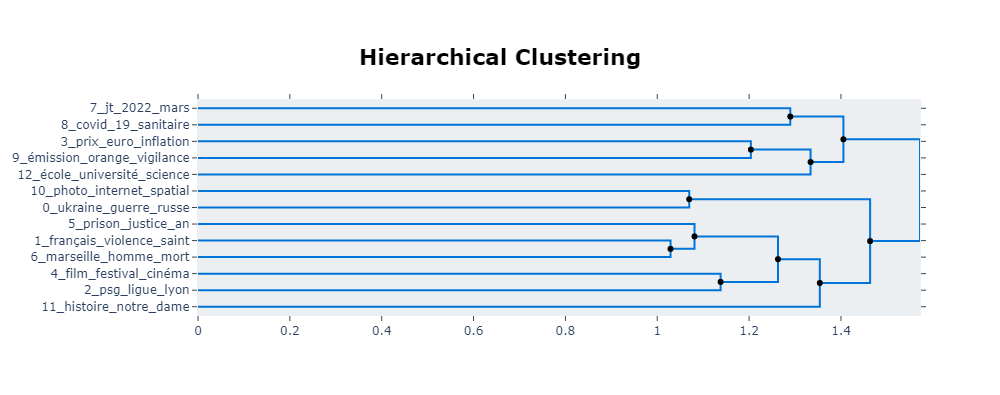

In [412]:
fig = topic_model.visualize_hierarchy(hierarchical_topics=hierarchical_topics)
fig.show('png')

In [411]:
new_labels = ['Politique France','International','Société','Sports','Economie', 'Culture & loisirs','Justice','Faits divers', 'NA', 'Santé',
'Environnement', 'Science & technique','Histoire & hommages', 'Education' ]
topic_model.set_topic_labels(new_labels)

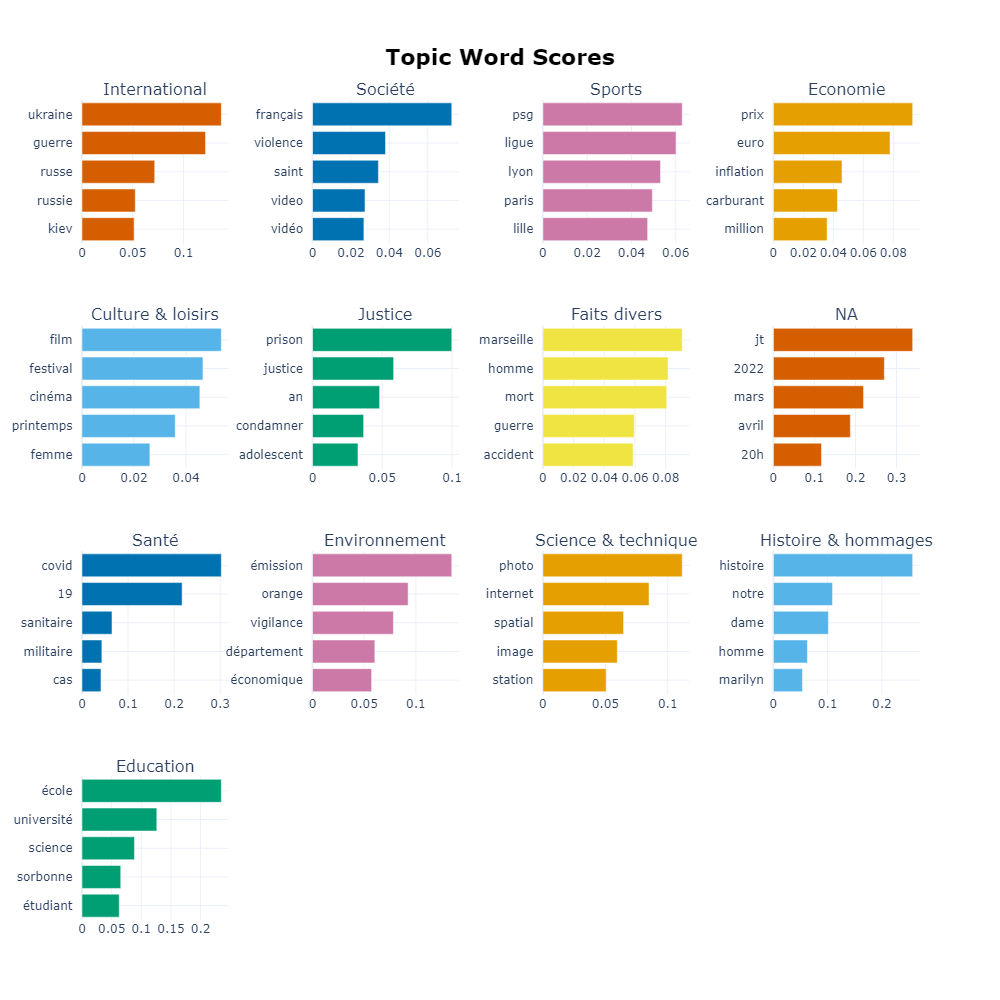

In [413]:
fig = topic_model.visualize_barchart(custom_labels=True,top_n_topics=20)
fig.show('png')

In [423]:
labels_list = []
for e in topic_model.topics_:
    labels_list.append(new_labels[e+1])

In [437]:
data[data['topic']==np.nan]['topic'] = labels_list

In [ ]:
data.to_csv('scraping/full_clean_lemma_topic.csv', index=False)